# Exploring Interest Rates, Bond Valuation, and Credit Risk

This Jupyter notebook explores various aspects of quantitative finance, focusing on interest rates, bond valuation, and credit risk analysis. It uses real-world data to analyze the yield curve for different maturities and demonstrates how to use cubic spline interpolation to construct an interpolated yield curve.

The notebook then delves into bond valuation, calculating the value of a bond based on its face value, coupon rate, and yield curve. It also discusses forward rates, duration, and convexity, important metrics for assessing bond price sensitivity to interest rate changes.

In this notebook, we will apply the Vasicek interest rate model to simulate interest rate paths and examine the Merton model to estimate the probability of default and credit spread based on asset volatility and debt levels.

This notebook provides a comprehensive overview of key concepts in quantitative finance, offering practical insights for financial analysts in interest and credit risk.

In [1]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
from scipy.interpolate import CubicSpline

In [3]:
fred = Fred(api_key='f5af5b95d623250968fae42d2586fd87')

# Example: Get the 1-Year, 2-Year, 5-Year, and 10-Year Treasury Constant Maturity Rates
series_ids = ['DGS1', 'DGS2', 'DGS5', 'DGS10']
data = pd.DataFrame({series_id: fred.get_series(series_id) for series_id in series_ids})

# Drop rows with missing values
data.dropna(inplace=True)

# Display the first few rows
data.tail()

,DGS1,DGS2,DGS5,DGS10
2024-05-28,5.21,4.94,4.56,4.54
2024-05-29,5.22,4.96,4.63,4.61
2024-05-30,5.19,4.92,4.57,4.55
2024-05-31,5.18,4.89,4.52,4.51
2024-06-03,5.14,4.82,4.42,4.41


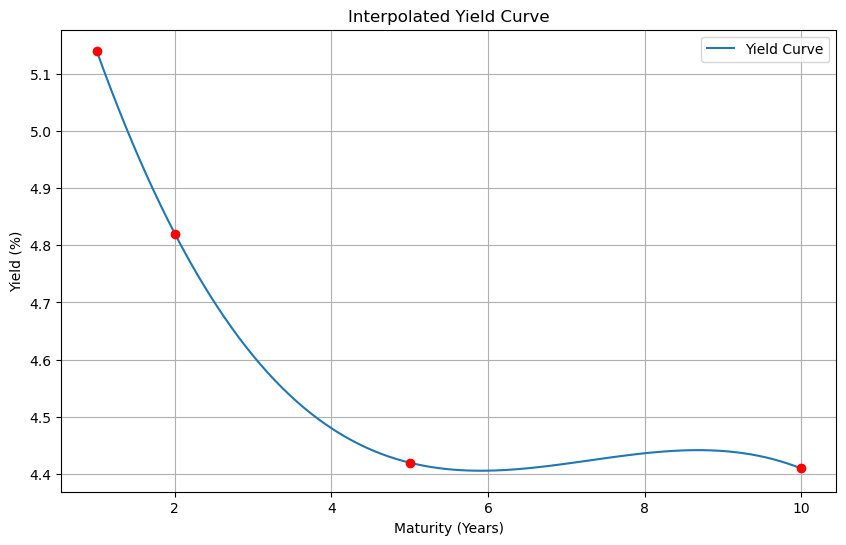

In [4]:
maturities = np.array([1, 2, 5, 10])
yields = data.iloc[-1].values  # Using the most recent data point for the example

# Construct the yield curve using cubic spline interpolation
spline = CubicSpline(maturities, yields)
curve = spline(np.linspace(1, 10, 100))

# Plot the yield curve
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(1, 10, 100), curve, label='Yield Curve')
plt.scatter(maturities, yields, color='red', zorder=5)
plt.title('Interpolated Yield Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
face_value = 1000
coupon_rate = 0.05  # 5%
bond_maturities = np.array([1, 2, 3, 4, 5])
yield_curve = spline(bond_maturities)

# Define the bond valuation function
def bond_valuation(face_value, coupon_rate, maturities, yield_curve):
    cash_flows = np.array([coupon_rate * face_value] * len(maturities))
    cash_flows[-1] += face_value  # Add face value to the last cash flow
    discount_factors = (1 + yield_curve / 100) ** (-maturities)
    present_value = np.sum(cash_flows * discount_factors)
    return cash_flows, discount_factors, present_value

# Calculate bond value, cash flows, and discount factors
cash_flows, discount_factors, bond_value = bond_valuation(face_value, coupon_rate, bond_maturities, yield_curve)
print(f'Bond Value: {bond_value}')

Bond Value: 1024.5098942692239


In [6]:
def forward_rate(spot_rate_1, spot_rate_2, t1, t2):
    return ((1 + spot_rate_2 / 100) ** t2 / (1 + spot_rate_1 / 100) ** t1) ** (1 / (t2 - t1)) - 1

# Example forward rate from 2-year to 3-year
spot_rate_2 = yield_curve[1]  # 2-year spot rate
spot_rate_3 = yield_curve[2]  # 3-year spot rate

f_rate = forward_rate(spot_rate_2, spot_rate_3, 2, 3)
print(f'Forward Rate (2-year to 3-year): {f_rate * 100:.2f}%')

Forward Rate (2-year to 3-year): 4.18%


In [7]:
# Define duration and convexity functions
def macaulay_duration(cash_flows, discount_factors, present_value):
    weighted_cash_flows = cash_flows * discount_factors * np.arange(1, len(cash_flows) + 1)
    return np.sum(weighted_cash_flows) / present_value

def modified_duration(macaulay_duration, yield_to_maturity):
    return macaulay_duration / (1 + yield_to_maturity / 100)

def convexity(cash_flows, discount_factors, present_value, yield_to_maturity):
    weighted_cash_flows = cash_flows * discount_factors * (np.arange(1, len(cash_flows) + 1) ** 2 + np.arange(1, len(cash_flows) + 1))
    return np.sum(weighted_cash_flows) / (present_value * (1 + yield_to_maturity / 100) ** 2)

# Example yield to maturity
ytm = 1.5

# Calculate Macaulay duration, modified duration, and convexity
mac_dur = macaulay_duration(cash_flows, discount_factors, bond_value)
mod_dur = modified_duration(mac_dur, ytm)
bond_convexity = convexity(cash_flows, discount_factors, bond_value, ytm)

print(f'Macaulay Duration: {mac_dur}')
print(f'Modified Duration: {mod_dur}')
print(f'Convexity: {bond_convexity}')

Macaulay Duration: 4.554844554080766
Modified Duration: 4.48753158037514
Convexity: 25.681035151542222


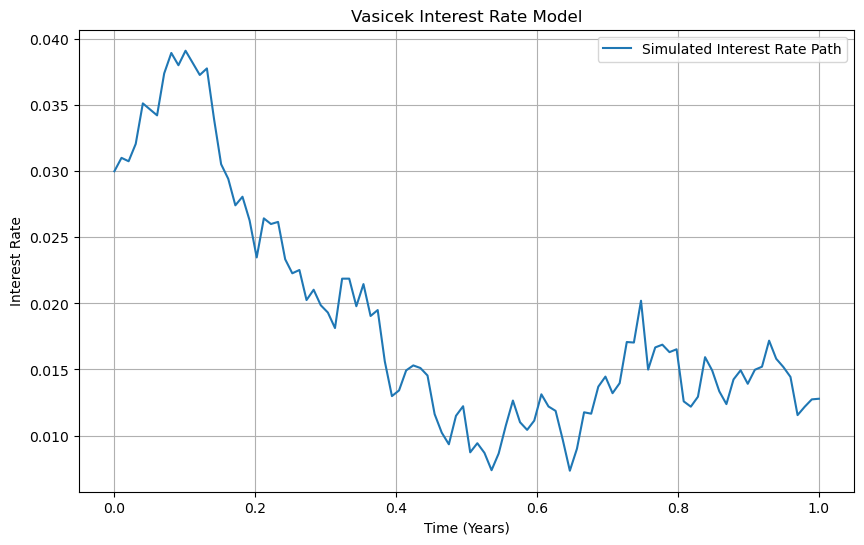

In [8]:
# Vasicek model parameters
alpha = 0.1  # Speed of reversion
b = 0.05  # Long-term mean level
sigma = 0.02  # Volatility
r0 = 0.03  # Initial interest rate
T = 1.0  # Time horizon
dt = 0.01  # Time step
n_steps = int(T / dt)

# Generate interest rate paths
np.random.seed(42)
r = np.zeros(n_steps)
r[0] = r0
for t in range(1, n_steps):
    dr = alpha * (b - r[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    r[t] = r[t-1] + dr

# Plot the simulated interest rate path
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, n_steps), r, label='Simulated Interest Rate Path')
plt.title('Vasicek Interest Rate Model')
plt.xlabel('Time (Years)')
plt.ylabel('Interest Rate')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from scipy.stats import norm

# Merton model parameters
V0 = 100  # Initial value of assets
sigma_V = 0.2  # Asset volatility
D = 80  # Debt level (face value of the debt)
T = 1.0  # Time to maturity (in years)

# Simulate risk-free rate using Vasicek model
alpha = 0.1  # Speed of reversion
b = 0.05  # Long-term mean level
sigma = 0.02  # Volatility
r0 = 0.03  # Initial interest rate
dt = 0.01  # Time step
n_steps = int(T / dt)

# Generate interest rate paths using Vasicek model
np.random.seed(42)
r = np.zeros(n_steps)
r[0] = r0
for t in range(1, n_steps):
    dr = alpha * (b - r[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    r[t] = r[t-1] + dr

# Calculate average risk-free rate over the period
r_avg = np.mean(r)

# Merton model: calculate d1 and d2
d1 = (np.log(V0 / D) + (r_avg + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
d2 = d1 - sigma_V * np.sqrt(T)

# Calculate the probability of default (PD)
PD = norm.cdf(-d2)

# Calculate credit spread (assuming a recovery rate of 40%)
LGD = 0.6  # Loss Given Default (1 - Recovery Rate)
credit_spread = PD * LGD

print(f'Probability of Default (PD): {PD * 100:.2f}%')
print(f'Credit Spread: {credit_spread * 100:.2f}%')

Probability of Default (PD): 13.36%
Credit Spread: 8.02%


# Summary

Current Interest Rates: The interpolated yield curve shows the following yields for different maturities as of the most recent data:

1-Year: 5.14%
2-Year: 4.82%
5-Year: 4.42%
10-Year: 4.41%

Bond Valuation: Using a face value of 1000 and a coupon rate of 5 percent the calculated bond value is approximately $1024.51.

Forward Rate: The forward rate from the 2-year to 3-year maturity is approximately 4.18%.

Duration and Convexity: For the bond, the Macaulay Duration is approximately 4.55 years, the Modified Duration is approximately 4.49, and the Convexity is approximately 25.68.

Vasicek Model: Simulating interest rate paths using the Vasicek model shows an evolving interest rate path over time, reflecting the stochastic nature of interest rate movements.

Merton Model: Based on the Merton model and the simulated risk-free rate, the Probability of Default (PD) is approximately 13.36%, and the Credit Spread is approximately 8.02%.

Summary on Current Interest Rates and the Economy: The current yield curve indicates a relatively steepening slope, with short-term rates higher than long-term rates. This can suggest expectations of future economic growth and inflation. The bond valuation and interest rate models provide insights into pricing and risk assessment in the financial markets. The Merton model's estimation of the Probability of Default and Credit Spread gives an indication of the current credit risk environment, which is influenced by factors such as economic conditions and market sentiment.